In [264]:
# Imports 
import pandas as pd
import numpy as np
import os

import plotly
import plotly.plotly as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='mrbalikci', api_key='UOYflXmBJelkNxcCHA0y')

%matplotlib inline

In [279]:
# read the data with all default parameters 
df = pd.read_csv('DellGSPE_DSrole_dataset.csv', index_col='asst_id', encoding='utf-8', low_memory=False)

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 16664
Data columns (total 18 columns):
product_type           99980 non-null object
mnfture_wk             100000 non-null int64
contract_st            100000 non-null int64
contract_end           100000 non-null int64
contact_wk             100000 non-null int64
contact_type           99986 non-null object
issue_type             85958 non-null object
topic_category         66916 non-null object
parts_sent             54566 non-null object
repair_type            100000 non-null object
repeat_ct              100000 non-null int64
parts_ct               100000 non-null int64
agent_tenure_indays    99986 non-null float64
contact_manager_flg    100000 non-null int64
diagnostics            100000 non-null object
repeat_parts_sent      13346 non-null object
region                 99997 non-null object
country                89998 non-null object
dtypes: float64(1), int64(7), object(10)
memory usage: 14.5+ MB


In [281]:
# take care of missing values for numerical columns 
# replace NaNs with '-888'
df['agent_tenure_indays']=df['agent_tenure_indays'].fillna('-888')

In [282]:
# replace NaNs with 'Unknown' for object type columns
df = df.fillna('Unknown')

# VOICE and Voice can be combined as 'Voice'
df['contact_type']=df['contact_type'].str.replace('VOICE','Voice')

### Time Related Columns to DateTime format

In [283]:
# change type to string
df['mnfture_wk']=df['mnfture_wk'].astype(str)
df['contract_st']=df['contract_st'].astype(str)
df['contract_end']=df['contract_end'].astype(str)
df['contact_wk']=df['contact_wk'].astype(str)

# taking care of mnfture
df['mnfture_year'] = df['mnfture_wk'].str[0:4]
df['mnfture_week'] = df['mnfture_wk'].str[4:6]
df["mnfture_datetime"] = pd.to_datetime(df.mnfture_week.astype(str)+
                          df.mnfture_year.astype(str).add('-0') ,format='%W%Y-%w')

# taking care of contact year
df['contact_year'] = df['contact_wk'].str[0:4]
df['contact_week'] = df['contact_wk'].str[4:6]
df["contact_week_datetime"] = pd.to_datetime(df.contact_week.astype(str)+
                          df.contact_year.astype(str).add('-0') ,format='%W%Y-%w')

# taking care of contract end year
df['contract_year'] = df['contract_end'].str[0:4]
df['contract_week'] = df['contract_end'].str[4:6]
df["contract_end_datetime"] = pd.to_datetime(df.contract_week.astype(str)+
                          df.contract_year.astype(str).add('-0') ,format='%W%Y-%w')

# Data Insights

1. Exploring Total number of cases over time (Mnfcture_wk) to see if there is a particular spike at any point in time. This could point to some issues in the manufacturing process/batch related to the weeks and help identify the root causes.

The analysis above could be done in more granular levels, say per product type, issue type etc, topic category etc.

### Number of Cases Over Time: Each Machine Sold

In [289]:
# get the total case of each machine sold
df_asst_id = df.reset_index()
df_asst_id = pd.DataFrame(df_asst_id.asst_id.value_counts())
df_asst_id.head()

,asst_id
72568,46
5183,18
7715,14
18338,7
11152,6


<strong>Conclusion</strong>: It seems one machine sold 46 times so further analysis on this particular case will not be needed.

### Number of Cases Over Time: Manufactured

In [290]:
# Manufactured week count
df_count_mnfture_wk = pd.DataFrame(df.mnfture_datetime.value_counts())
df_count_mnfture_wk = df_count_mnfture_wk.rename(columns={'mnfture_datetime':'count'}).reset_index()
df_count_mnfture_wk = df_count_mnfture_wk.rename(columns={'index':'mnfture_datetime'})
df_count_mnfture_wk.head()

,mnfture_datetime,count
0,2018-09-30,1340
1,2018-07-01,1312
2,2018-06-24,1072
3,2018-01-07,1053
4,2018-04-01,938


In [291]:
# Bar-Chart for Manufactured vs Cases Over Time

x=df_count_mnfture_wk['mnfture_datetime']
y=df_count_mnfture_wk['count'] 

data = [
    go.Bar(
        x=x, # assign x as the dataframe column 'x'
        y=y
    )
]

layout = go.Layout(
    barmode='stack',
    title='Manufactured vs Cases Over Time'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

<strong>Conclusion</strong>:
* As seen from the bar-chart there is positive correlation of cases all the way up to 2018 if 2019 cases are ignored. 

* There is a spike in 2018 in terms of number of cases rising. Perhaps, this could point to some of the issues in the manufacturing process/batch related to the weeks and help identify the root causes.

### Number of Cases Over Time: Product Type



In [292]:
# grab data for product type and number of cases over time
df_count_product_type = pd.DataFrame(df.product_type.value_counts(normalize=True)).reset_index()
df_count_product_type = df_count_product_type.rename(columns={'product_type':'count'})
df_count_product_type = df_count_product_type.rename(columns={'index':'product_type'})
df_count_product_type.head()

,product_type,count
0,Laptops,0.73052
1,Desktops,0.23601
2,Other Electronics,0.03327
3,Unknown,0.00020


In [293]:
# use plotly to plot these findings
x=df_count_product_type['product_type']
y=df_count_product_type['count'] 

data = [
    go.Bar(
        x=x,
        y=y
    )
]

py.iplot(data)

<strong>Conclusion</strong>: 
* As seen above laptops seem giving more issues compared with other product types.
* Almost 73% of cases are over laptops as seen from the cart. 

### Number of Cases Over Time: Repair Type

In [294]:

df_count_repair_type = pd.DataFrame(df.repair_type.value_counts(normalize=True)).reset_index()
df_count_repair_type = df_count_repair_type.rename(columns={'repair_type':'count'})
df_count_repair_type = df_count_repair_type.rename(columns={'index':'repair_type'})
df_count_repair_type.head()

,repair_type,count
0,Hard,0.59495
1,Soft,0.40505


In [295]:
x=df_count_repair_type['repair_type']
y=df_count_repair_type['count'] 

data = [
    go.Bar(
        x=x, # assign x as the dataframe column 'x'
        y=y
    )
]

py.iplot(data)

<strong>Conclusion</strong>:
* Approximately 59% of issues are related to hard-ware problems.

### Number of Cases Over Time: Parts Sent

In [296]:
# filtering data 
df_count_parts_sent = pd.DataFrame(df.parts_sent.value_counts(normalize=True)).reset_index()
df_count_parts_sent = df_count_parts_sent.rename(columns={'parts_sent':'percent'})
df_count_parts_sent = df_count_parts_sent.loc[df_count_parts_sent['percent'] >0.003,:]
df_count_parts_sent = df_count_parts_sent.rename(columns={'index':'parts_sent'})
# df_count_parts_sent = df_count_parts_sent.iloc[1:] # 45% 'unknown' is dropped
df_count_parts_sent.head()

,parts_sent,percent
0,Unknown,0.45434
1,Hard Drive,0.04504
2,"Motherboard, Documentation",0.04405
3,LCD Panel,0.03022
4,Keyboard,0.02981


In [297]:
# plot the data

x=df_count_parts_sent['parts_sent']
y=df_count_parts_sent['percent'] 

data = [
    go.Bar(
        x=x, # assign x as the dataframe column 'x'
        y=y
    )
]

py.iplot(data)

<strong>Conclusion</strong>:
* Hard Drive, Motherboard, LCD Panel are top 3 items sent more and more compared to the other parts over time
* About 45% of the parts sent over time is 'unknown'.

### Number of Cases Over Time: Contact Type

In [298]:
# data for contact type

df_count_contact_type = pd.DataFrame(df.contact_type.value_counts(normalize=True)).reset_index()
df_count_contact_type = df_count_contact_type.rename(columns={'contact_type':'percent'})
df_count_contact_type = df_count_contact_type.rename(columns={'index':'contact_type'})
df_count_contact_type

,contact_type,percent
0,Voice,0.84162
1,CHAT,0.14425
2,EMAIL,0.01281
3,Unknown,0.00132


In [299]:
# plot the data 

x=df_count_contact_type['contact_type']
y=df_count_contact_type['percent']

data = [
    go.Bar(
        x=x,
        y=y
    )
]

py.iplot(data)

<strong>Conclusion</strong>:
* Voice is preferred as the main source of contact for the issues reporting with 84% rate. 

### Number of Cases Over Time: Topic Category

In [300]:
# data for topic category
df_count_topic_category = pd.DataFrame(df.topic_category.value_counts(normalize=True)).reset_index()
df_count_topic_category = df_count_topic_category.rename(columns={'topic_category':'percent'})
df_count_topic_category = df_count_topic_category.rename(columns={'index':'topic_category'})
df_count_topic_category.head(10)

,topic_category,percent
0,Unknown,0.33084
1,Booting,0.15343
2,LCD/Monitor,0.05452
3,Call Logs,0.04837
4,General Queries,0.04141
5,Hard Drive,0.03534
6,System Performance,0.03459
7,Internet/Wireless,0.03093
8,Keyboard,0.02666
9,Battery,0.02478


In [301]:
x=df_count_topic_category['topic_category']
y=df_count_topic_category['percent'] 

data = [
    go.Bar(
        x=x, # assign x as the dataframe column 'x'
        y=y
    )
]

py.iplot(data)

<strong>Conclusion</strong>:
* Booting, LCD/Monitor, Call Logs are top 3 topic categories that are classified as 
    problem by tech support

### Number of Cases Over Time: Region

In [302]:
# gather the data
df_region_country = pd.DataFrame(df.groupby(['region','country']).agg({'region':'count', 'country':'count'}))
df_region_country = df_region_country.rename(columns={'region':'region_count', 'country':'country_count'}).reset_index()
df_region_country.head()

,region,country,region_count,country_count
0,Hogwarts,Diagon Alley,4,4
1,Hogwarts,Gryffindor,17,17
2,Hogwarts,Hog's Head Inn,3,3
3,Hogwarts,Honeyduke's,24,24
4,Hogwarts,Hufflepuff,52,52


<strong>Conclusion</strong>:
Assumed this data is a mock up data so region and country alignment does not make any sense to analyze

### Number of Cases over Time: Product and Repair Types

In [303]:
# Merge product type and repair type and aggregate it based on manufactured week count

df_repair_type_cases_over_time = pd.DataFrame(df.groupby(['product_type','repair_type']).mnfture_wk.count()).sort_values('mnfture_wk', ascending=False)
df_repair_type_cases_over_time = df_repair_type_cases_over_time.rename(columns={'mnfture_wk':'number_of_cases'}).reset_index()
df_repair_type_cases_over_time["product_repair_type"] = df_repair_type_cases_over_time["product_type"].map(str) +"-"+ df_repair_type_cases_over_time["repair_type"]
df_repair_type_cases_over_time['prc_of_cases'] = (df_repair_type_cases_over_time['number_of_cases']/(df_repair_type_cases_over_time['number_of_cases'].sum()))*100
df_repair_type_cases_over_time.head(10)

,product_type,repair_type,number_of_cases,product_repair_type,prc_of_cases
0,Laptops,Hard,45897,Laptops-Hard,45.897
1,Laptops,Soft,27155,Laptops-Soft,27.155
2,Desktops,Soft,12047,Desktops-Soft,12.047
3,Desktops,Hard,11554,Desktops-Hard,11.554
4,Other Electronics,Hard,2043,Other Electronics-Hard,2.043
5,Other Electronics,Soft,1284,Other Electronics-Soft,1.284
6,Unknown,Soft,19,Unknown-Soft,0.019
7,Unknown,Hard,1,Unknown-Hard,0.001


In [304]:
# bar-plot for the data above

data = [
    go.Bar(
        x=df_repair_type_cases_over_time['product_repair_type'], # assign x as the dataframe column 'x'
        y=df_repair_type_cases_over_time['prc_of_cases'],
        name = 'Product Type'
    )
]

layout = go.Layout(
    barmode='stack',
    title='Product-Repair Types vs Number of Cases'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

<strong>Conclusion</strong>:
* Product type 'Laptop' and Repair Type 'Hard' issues seem the most reported

- We can look into the correlations between agent_tenure_indays and parts_ct, contact_manager_flg, repeat_ct etc. to understand where the new agents are struggling. We can add another dimension for topic category to see if some topics are harder to identify for the new agents than others.

### Correlations: Agent Tenure Indays vs Contact Manager Flg

In [305]:
# change the type from object to numerical 
df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)

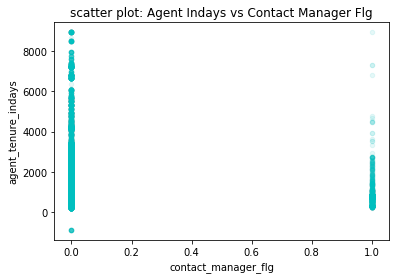

In [306]:
# scatter plot for agent tenure indays vs contacted manager 
df.plot.scatter(y='agent_tenure_indays', 
                x='contact_manager_flg', 
                color='c', 
                title='scatter plot: Agent Indays vs Contact Manager Flg',
                alpha=0.1);

In [307]:
# find the percent of number of agents who has experience less than 1018 days or equal. 
df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)
df_agent_to_contact_mngr = pd.DataFrame(df.groupby('agent_tenure_indays').contact_manager_flg.count()).\
                            sort_values('contact_manager_flg', ascending=False).reset_index()
df_agent_to_contact_mngr['percent'] = (df_agent_to_contact_mngr['contact_manager_flg']/\
                                       df_agent_to_contact_mngr['contact_manager_flg'].sum())*100

prc = round((df_agent_to_contact_mngr.\
             loc[df_agent_to_contact_mngr['agent_tenure_indays']<=1018,:]).\
            percent.sum(),0)

print(f"{prc}% of agents who has experience <= 1018 days tends to get help from their superiors.")

77.0% of agents who has experience <= 1018 days tends to get help from their superiors.


<strong>Conclusion</strong>:

* Based on the plot above, it can be seen that inexperienced agents sent to take the matter to the contacting manager. 

* From the <em>df_agent_to_contact_mngr</em> that more inexperienced agents tends to contact to their superior comparing experienced ones.

* 77.0% of agents who got experience <= 1018 days tend to get help from their superiors.


### Correlations: Agent Tenure Indays vs Additional Visits

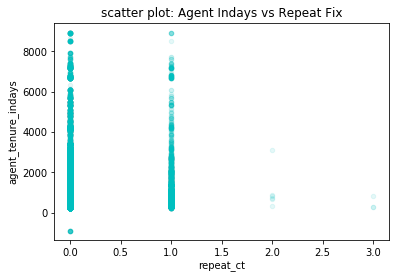

In [308]:
# scatter plot for agent tenure indays vs additional visits
df.plot.scatter(y='agent_tenure_indays', 
                x='repeat_ct', 
                color='c', 
                title='scatter plot: Agent Indays vs Repeat Fix',
                alpha=0.1);

<strong>Conclusion</strong>:
* More additional visits were made by more inexperienced tech support comparing experienced ones.

### Correlations: Agent Tenure Indays vs Parts Sent

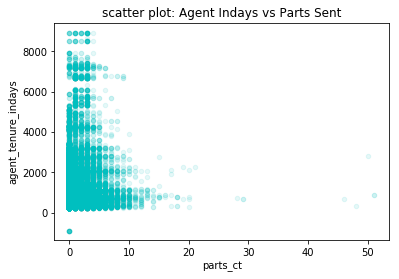

In [309]:
# scatter plot for agent tenure indays and number of parts were sent to fix problem
df.plot.scatter(y='agent_tenure_indays', 
                x='parts_ct', 
                color='c', 
                title='scatter plot: Agent Indays vs Parts Sent',
                alpha=0.1);

<strong>Conclusion</strong>:
* More parts were sent by inexperienced agents 

- We can look into the correlation between the repeat_ct and contact_type to see if some communication channels are more effective than others.


### Correlations: Additional Parts Sent vs Contact Type

In [310]:
# Assigned numerical values to the contact types for correlation
df['contact_type']=df['contact_type'].str.replace('Voice',"1")
df['contact_type']=df['contact_type'].str.replace('CHAT',"2")
df['contact_type']=df['contact_type'].str.replace('EMAIL',"3")
df['contact_type']=df['contact_type'].str.replace('Unknown',"4")

In [311]:
# change data type to numerical 
df['contact_type']=df['contact_type'].astype(int)

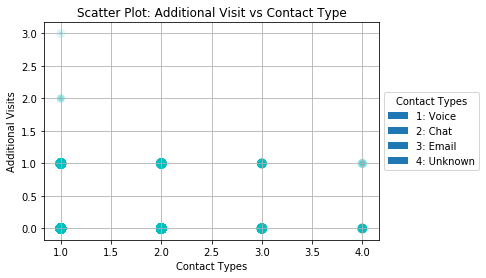

In [312]:
# matplotlib imports 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# plot the additional parts sent vs contact type 
N=50
x = df.contact_type
y = df.repeat_ct
colors = np.random.rand(N)
area = (10 * np.random.rand(N))**2  # 0 to 15 point radii

voice = mpatches.Patch(label='1: Voice')
chat = mpatches.Patch(label='2: Chat')
email = mpatches.Patch(label='3: Email')
unknown = mpatches.Patch(label='4: Unknown')

plt.scatter(x, y, s=area, c='c', alpha=0.1)
plt.legend(handles=[voice, chat, email, unknown])
plt.title('Scatter Plot: Additional Visit vs Contact Type')
plt.legend(handles=[voice, chat, email, unknown], 
           loc='center left', bbox_to_anchor=(1, 0.5), title="Contact Types",fancybox=True)
plt.xlabel('Contact Types')
plt.ylabel('Additional Visits')
plt.grid()
plt.show()

<strong>Conclusion</strong>:
* Voice contact type seems got more additional visits required to fix the problem

- We can look into the correlation between diagnostics and repeat_ct to see if diagnostics are helpful to the agents. We can run a hypothesis testing to see if the effect is significant.

### Correlations: Diagnostics vs Additional Visits

In [313]:
# Assigned numerical values for type of diagnostics 
df_diag = df
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('Not_USED','1')
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('Effective_Usage','2')
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('InEffective_Usage','3')
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('Not_Considered','4')

# somehow 'inEffective_Usage' replace with 'in2' object so replaced it with 3 again
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('In2','3')

In [314]:
# change type from object to numeric to plot
df_diag['diagnostics']=df_diag['diagnostics'].astype(int)

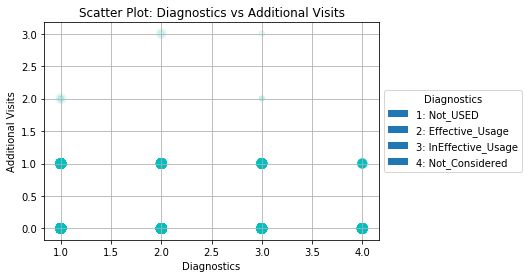

In [315]:
# Scatter Plot for Diagnostics vs Additional Visits

N=50
x = df_diag.diagnostics
y = df_diag.repeat_ct
colors = np.random.rand(N)
area = (10 * np.random.rand(N))**2  # 0 to 15 point radii

not_used = mpatches.Patch(label='1: Not_USED')
eff_usag = mpatches.Patch(label='2: Effective_Usage')
ineff_usag = mpatches.Patch(label='3: InEffective_Usage')
not_cons = mpatches.Patch(label='4: Not_Considered')

plt.scatter(x, y, s=area, c='c', alpha=0.1)
plt.legend(handles=[not_used, eff_usag, ineff_usag, not_cons], 
           loc='center left', bbox_to_anchor=(1, 0.5), title="Diagnostics",fancybox=True)
plt.title('Scatter Plot: Diagnostics vs Additional Visits')
plt.xlabel('Diagnostics')
plt.ylabel('Additional Visits')
plt.grid()
plt.show()

<strong>Conclusion</strong>:
* It is hard to determine which diagnostics type was effective so used hypothesis testing below. 

### Hypothesis Testing: To see if the effect is significant

* Hypothesis: If diagnostic is effectively been used for each case, there is a significant effect on customer's additional visit

* Null Hypothesis: If diagnostics not effectively been used for each case, there is not a significant effect on customer's additional visit


In [316]:
# Dependencies
import scipy.stats as stats

In [317]:
# Only get diagnostics and repeat_ct columns for testing
df_diag_repeat_ct = df[['diagnostics','repeat_ct']]
df_diag_repeat_ct.head()

,diagnostics,repeat_ct
asst_id,,
0,1,0
1,1,0
2,1,0
3,2,0
4,1,0


diagnostics
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Zscore, dtype: object

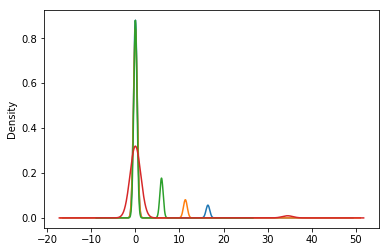

In [318]:
df_diag_normal_dist = df[['diagnostics','repeat_ct']].reset_index()
df_diag_normal_dist['Zscore'] = df_diag_normal_dist.groupby('diagnostics').repeat_ct.apply(lambda x: x.div(x.mean()))
df_diag_normal_dist.groupby('diagnostics').Zscore.plot.kde()

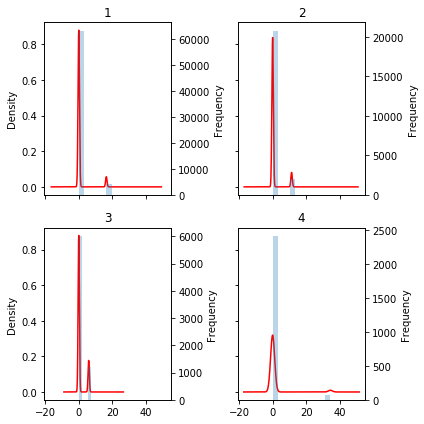

In [319]:
g = df_diag_normal_dist.groupby('diagnostics').Zscore
n = g.ngroups
fig, axes = plt.subplots(n // 2, 2, figsize=(6, 6), sharex=True, sharey=True)
for i, (name, group) in enumerate(g):
    r, c = i // 2, i % 2
    a1 = axes[r, c]
    a2 = a1.twinx()
    group.plot.hist(ax=a2, alpha=.3)
    group.plot.kde(title=name, ax=a1, c='r')
fig.tight_layout()

In [320]:
# Calculate additional visits mean for diagnostics Not_Used which (1) and Effective_Usage (2)
not_used = df_diag_repeat_ct[df_diag_repeat_ct['repeat_ct']==1]
print(f"mean for diagnostics not used {not_used.diagnostics.mean()}")

effective_usage = df_diag_repeat_ct[df_diag_repeat_ct['repeat_ct']==2]
print(f"mean for diagnostics used {effective_usage.diagnostics.mean()}")

mean for diagnostics not used 1.6292636708175419
mean for diagnostics used 2.0


In [321]:
# function to create scatter and histogram plots comparison 

def gendata(loc1=0, loc2=0):
    not_used_diag = not_used.diagnostics
    effective_usage_diag = effective_usage.diagnostics
    
    # scatter plot of data
    plt.subplot(2,1,1)
    plt.scatter(range(len(not_used_diag)), not_used_diag, label='not used diagnostics')
    plt.scatter(range(len(effective_usage_diag)), effective_usage_diag, label='effective usage diagnostics')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # histogram plot of data
    plt.subplot(2,1,2)
    plt.hist(not_used_diag, density=True, alpha=0.7, label='not used diagnostics')
    plt.hist(effective_usage_diag, density=True, alpha=0.7, label='effective usage diagnostics')
    plt.axvline(not_used_diag.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(effective_usage_diag.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return not_used_diag, effective_usage_diag

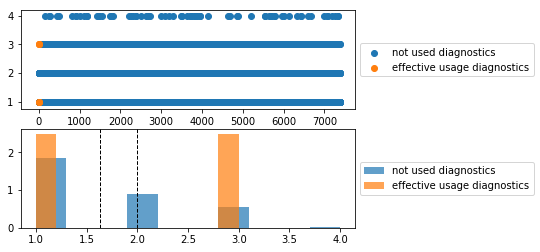

In [322]:
# run the fuction
not_used_diag, effective_usage_diag = gendata()

In [323]:
# Calculate Independent (Two Sample) T-Test
print(stats.ttest_ind(not_used.diagnostics, effective_usage.diagnostics, equal_var=False))

Ttest_indResult(statistic=-0.8288177050971959, pvalue=0.4449271956106138)


<strong>Conclusion</strong>:

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so fail to reject the null hypothesis.

* Null Hypothesis: If diagnostics not effectively been used for each case, there is not a significant effect on customer's additional visit

* That means, if the diagnostics are not effectively been used for each case, there is not a significant effect on customer's additional visit. 

- We can look into the relation between the time after manufacturing till contact week and topic parts_sent to see what parts are failing when.

In [324]:
# find the difference in days between contract end and manufacturing time
df['mnfture_to_contact']=df.contract_end_datetime-df.mnfture_datetime
df['mnfture_to_contact_in_days'] = df['mnfture_to_contact'].apply(lambda x: float(x.days))

In [332]:
# we got some negative numbers, filter for positive and zeros
df = df.loc[df.mnfture_to_contact_in_days >= 0,:]

In [326]:
df_mnfture_to_contract = pd.DataFrame(df.groupby('parts_sent').mnfture_to_contact_in_days.mean()).\
            sort_values('mnfture_to_contact_in_days', ascending=True)
df_mnfture_to_contract.head(10)

,mnfture_to_contact_in_days
parts_sent,
"Miscellaneous(2), LCD Panel(6)",147.000000
"Printer, Base Unit",168.000000
"Miscellaneous(2), Battery (Other)(2)",231.000000
"Miscellaneous(2), LCD Panel(2), Hard Drive",256.666667
"Speaker(2), Motherboard, Miscellaneous, Heatsink, Documentation",259.000000
"Motherboard(5), Miscellaneous, Cables(2)",266.000000
"Miscellaneous(2), Adapter, AC(5)",294.000000
"Miscellaneous, LCD Panel(2)",294.000000
"LCD, Adapter, AC",296.333333


<strong>Conclusion</strong>:
* The time after manufacturing till contact week and topic parts_sent to see what parts are failing shows that top 10 parts above. 
* These numbers were determined based on average numbers of manufacturing until contact week for each parts failing. 
* It seems LCD Panels, Base Unit, Printer, Battery, Hard Drive are top ones failing. 

- We can look into if people are contacting the support right before their warranty expires.


In [327]:
# find the difference in days between contact week and contract end time

df['contact_for_contract_end']=df.contact_week_datetime - df.contract_end_datetime
df['contact_for_contract_end'] = df['contact_for_contract_end'].apply(lambda x: float(x.days))
df = df.sort_values('contact_for_contract_end', ascending=True)

value =round((len(df.loc[(df['contact_for_contract_end']<=0) & \
                         (df['contact_for_contract_end']>-365) ,:])/len(df))*100,0)
print(f"{value}% of people who has their contract ending withing a year contacting to the tech support")

C:\Users\Adam\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36.0% of people who has their contract ending withing a year contacting to the tech support


C:\Users\Adam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



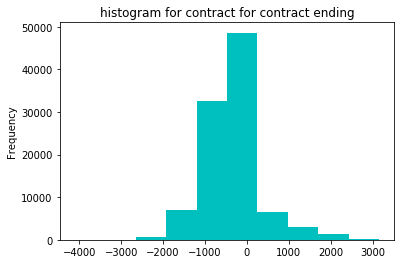

In [328]:
# Histogram for contact before contract ending 
df.contact_for_contract_end.plot(kind='hist', 
                                 title='histogram for contract for contract ending', 
                                 color='c');

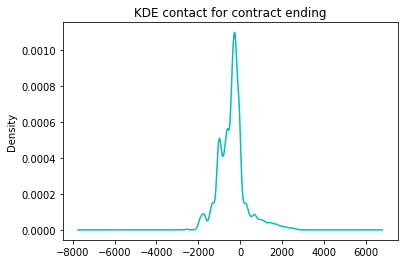

In [329]:
# kernel density estimation for contact for contract ending period 
df.contact_for_contract_end.plot(kind='kde', 
                                 title='KDE contact for contract ending', 
                                 color='c');

In [330]:
print('skewness for contact for contract ending: {0:2f}'.format(df.contact_for_contract_end.skew()))

skewness for contact for contract ending: 0.913336


<strong>Conclusion</strong>:
* 36% of people are contacting the tech support withing a year before their warranty expires

- We can look into the correlation between topic_category and repeat_ct to see if some problem types especially lead to additional visits.


In [331]:
df_test = df.groupby(['topic_category','repeat_ct']).repeat_ct.count().sort_values(0, ascending=True).unstack()
df_test=df_test.sort_values(2,ascending=False).groupby('topic_category').head()
df_test.head()

repeat_ct,0,1,2,3
topic_category,,,,
Call Logs,4548.0,280.0,4.0,2.0
Booting,13515.0,1825.0,1.0,NaN
Unknown,30512.0,2554.0,1.0,NaN
AC Adaptor,219.0,26.0,NaN,NaN
Antivirus,156.0,1.0,NaN,NaN


<strong>Conclusion</strong>:
* Type of problems as classified by the tech supports for additional visits are booting, LCD/Monitor, Call Logs, and hard drive